In [1]:
import pandas as pd
import qiime2 as q2
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.power import tt_ind_solve_power
from statistics import mean, stdev
from skbio import DistanceMatrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# Download data from Qiita

Full analysis can be found here: https://qiita.ucsd.edu/analysis/description/25761/. Note that you need to be logged into the system to open this link.

In [2]:
# Alpha diversity object 
! wget -q -O alpha_div_artifact.zip "https://qiita.ucsd.edu/public_artifact_download/?artifact_id=78883"
! unzip -qqqo alpha_div_artifact.zip
# Beta diversity object 
! wget -q -O beta_div_artifact.zip "https://qiita.ucsd.edu/public_artifact_download/?artifact_id=78884"
! unzip -qqqo beta_div_artifact.zip
# Mapping file
! wget -q -O metadata.zip "https://qiita.ucsd.edu/public_download/?data=sample_information&study_id=1629"
! unzip -qqqo metadata.zip

# Processing data

In [11]:
metadata = pd.read_csv('templates/1629_20230206-074214.txt', sep='\\t', dtype=str, index_col=0, engine='python')

metadata['deblur alpha diversity'] = q2.Artifact.load('alpha_vector/78883/alpha_diversity.qza').view(pd.Series)
metadata.dropna(subset=['deblur alpha diversity'], inplace=True)

b1 = metadata[metadata.cd_behavior == 'non-stricturing, non-penetrating (b1)']
bother = metadata[(metadata.cd_behavior != 'non-stricturing, non-penetrating (b1)') & 
                  (metadata.cd_behavior != 'not applicable')]

dtx = q2.Artifact.load('distance_matrix/78884/distance_matrix.qza').view(DistanceMatrix)

b1_dtx = dtx.filter(ids=b1.index).to_series().values
bother_dtx = dtx.filter(ids=bother.index).to_series().values

In [12]:
# alpha
sd1 = b1['deblur alpha diversity'].std()
sd2 = bother['deblur alpha diversity'].std()
sd12 = mean([sd1, sd2])

alpha = 0.05
data_alpha = []
for observations in range(10, 155, 5):
    for difference in [2, 3, 4]:
        effect_size = difference/sd12
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_alpha.append({
            'alpha': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_alpha = pd.DataFrame(data_alpha) 

# beta
u2u1 = abs(mean(b1_dtx) - mean(bother_dtx))
effect_size = u2u1/mean([stdev(b1_dtx), stdev(bother_dtx)])

data_beta = []
for observations in range(10, 155, 5):
    for alpha in [.001, .01, .05, .1]:
        x = tt_ind_solve_power(effect_size=effect_size, nobs1=observations, 
                               alpha=alpha, ratio=1.0,
                               alternative='two-sided')
        data_beta.append({
            'Significance level (α)': alpha, 'Power (1-β)': x, 
            'Total sample size (N)': observations * 2, 
            'Difference': '%d (effect size %0.2f)' % (
                difference, effect_size)})
data_beta = pd.DataFrame(data_beta) 

In [13]:
print ('Alpha diversity:',
    b1['deblur alpha diversity'].mean(),
    bother['deblur alpha diversity'].mean(),
    
    b1['deblur alpha diversity'].std(),
    bother['deblur alpha diversity'].std())

print ('Beta diversity:',
    mean(b1_dtx),
    mean(bother_dtx),
    
    stdev(b1_dtx),
    stdev(bother_dtx))

Alpha diversity: 13.566109944933606 9.758946179733023 3.4556252984107836 3.874910599348059
Beta diversity: 0.5576305261200442 0.6079230845960769 0.08657671364992668 0.09259071136535352


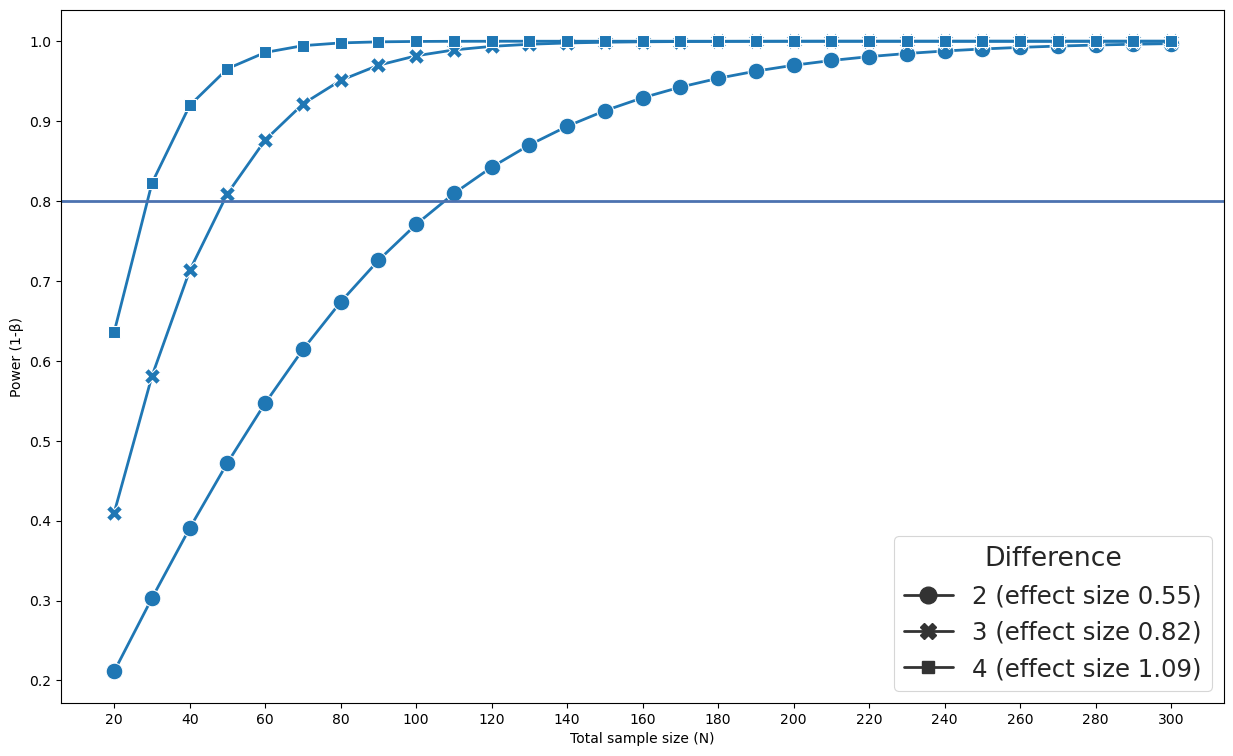

In [14]:
fig, ax1 = plt.subplots(figsize=(15, 9))

sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2, 
                rc={'lines.linewidth': 2, 'lines.markersize': 12})

f = sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
                 markers=True, dashes=False, style='Difference',
                 ax=ax1, data=data_alpha)
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

plt.axhline(0.8, 0, data_alpha['Total sample size (N)'].max())
fig.savefig('figure1.pdf')

/tmp/ipykernel_33231/742593124.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(b1_dtx, label="B1 within distances", color="red", ax=ax2)
/tmp/ipykernel_33231/742593124.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bother_dtx, label="B2-3 within distances", color="skyblue", ax=ax2)


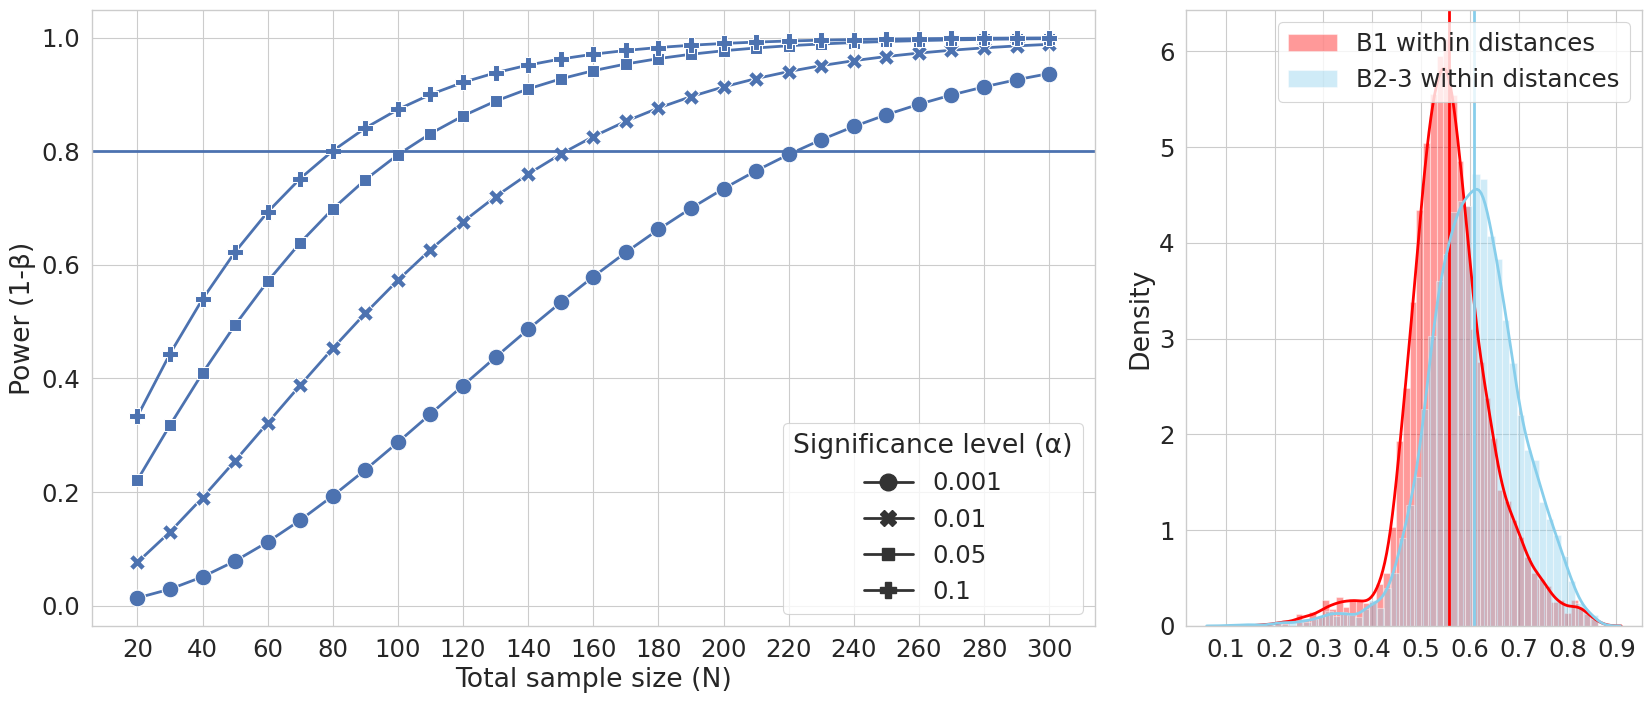

In [15]:
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(ncols=3, nrows=1, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(grid[0, :2])
ax2 = fig.add_subplot(grid[0, 2:])

sns.lineplot(x='Total sample size (N)', y='Power (1-β)',
             style='Significance level (α)',
             markers=True, dashes=False,
             ax=ax1, data=data_beta)
ax1.axhline(0.8, 0, data_beta['Total sample size (N)'].max())
ax1.xaxis.set_major_locator(plt.MultipleLocator(20))

sns.distplot(b1_dtx, label="B1 within distances", color="red", ax=ax2)
ax2.axvline(mean(b1_dtx), 0, 6, color="red")

sns.distplot(bother_dtx, label="B2-3 within distances", color="skyblue", ax=ax2)
ax2.axvline(mean(bother_dtx), 0, 6, color="skyblue")
ax2.xaxis.set_major_locator(plt.MultipleLocator(.1))
plt.legend()

fig.savefig('figure2.pdf')